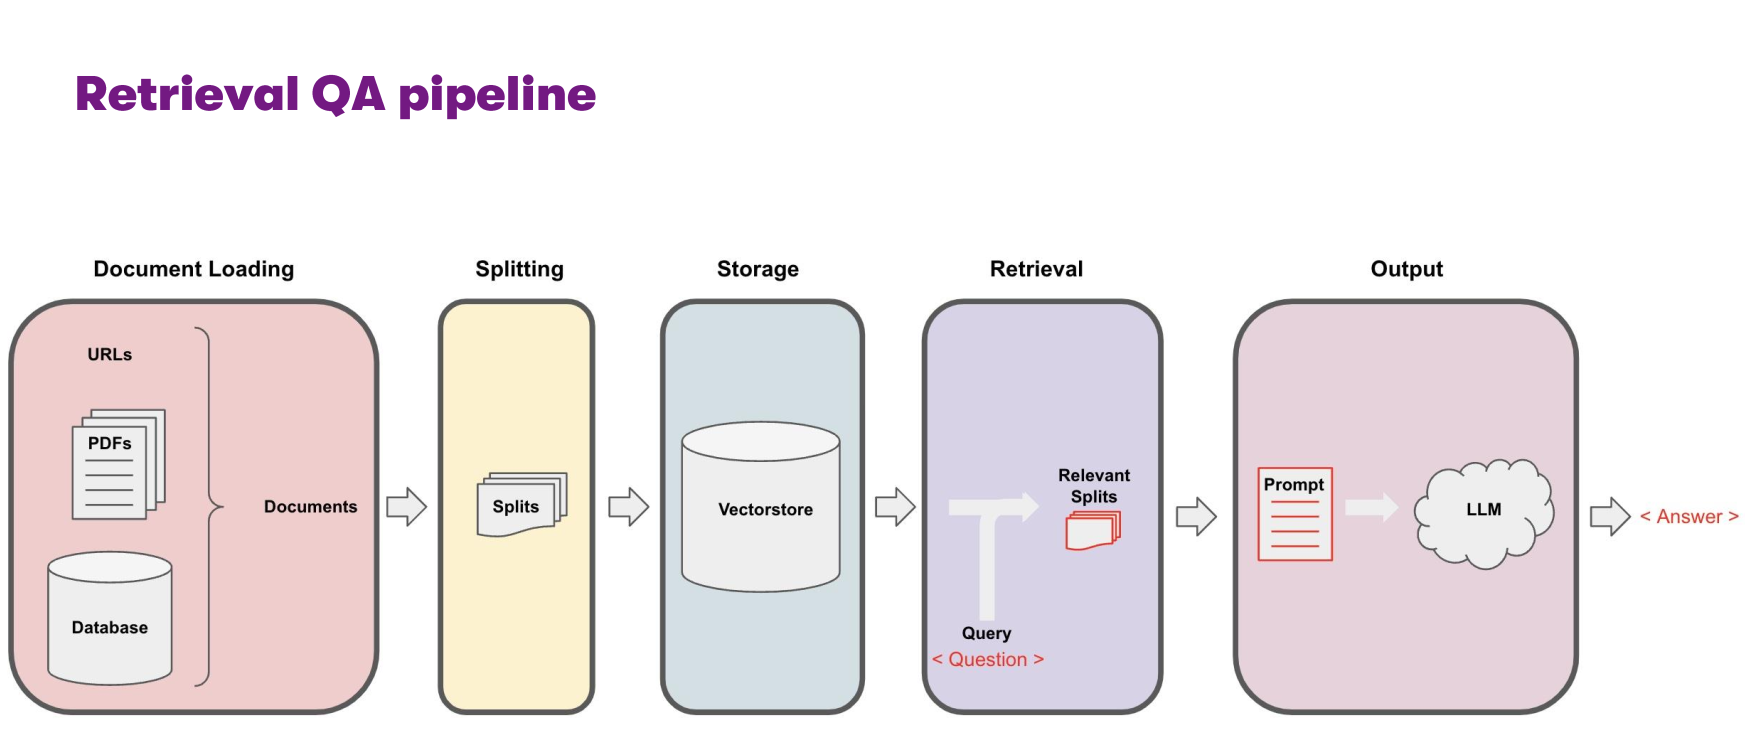

In [1]:
from parse_data import get_contexts, get_qa

import os

import sys
from dotenv import load_dotenv
import uuid
from tqdm.notebook import tqdm

from RunChatModel import run_chat_completion
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.schema import Document
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma

In [2]:
dotenv_path = os.path.join(os.getcwd(), '.env')
load_dotenv(dotenv_path)

token = os.environ["OCTOAI_TOKEN"]
endpoint = os.environ["ENDPOINT"]

In [3]:
qa = get_qa("datasets/triviaqa_train.json")
contexts = get_contexts("datasets/triviaqa_train.json")

In [8]:
LIMIT = 1000
qa_limit = qa[:LIMIT]
contexts_limit = contexts[:LIMIT]

In [9]:
# Подготовка контекста
doc_ids = [str(uuid.uuid4()) for _ in contexts_limit]
documents = [Document(page_content=s, metadata={"doc_id": doc_ids[i]}) for i, s in enumerate(contexts_limit)]
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)
# Создание векторной базы данных
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
db = Chroma.from_documents(docs, embedding_function)

In [10]:
def evaluation_with_context(model_name):
    acc = 0
    print(f"Run evaluation on {model_name} with context")
    for element in tqdm(qa_limit):
        question, answer = element["question"], element["answer"]
        
        relative_docs = db.similarity_search(question)
        messages = [
        {"role": "system", "content": "Answer only with one word. Use context."},
        {"role": "user", 
        "content": f"Question: {question}\n Context: {relative_docs[0].page_content}"}
        ]
        
        completion = run_chat_completion(model_name, messages, token, endpoint)
        acc += int(answer.lower() in completion["choices"][0]["message"]["content"].lower())

    return acc / len(qa_limit)

def evaluation_without_context(model_name):
    acc = 0
    print(f"Run evaluation on {model_name} without context")
    for element in tqdm(qa_limit):
        question, answer = element["question"], element["answer"]

        messages = [
        {"role": "system", "content": "Answer only with one word."},
        {"role": "user", "content": f"Question: {question}"}
        ]

        completion = run_chat_completion(model_name, messages, token, endpoint)
        acc += int(answer.lower() in completion["choices"][0]["message"]["content"].lower())

    return acc / len(qa_limit)

In [11]:
acc_llama_70b = evaluation_without_context("llama-2-70b-chat-fp16")
acc_llama_13b = evaluation_without_context("llama-2-13b-chat-fp16")
acc_llama_13b_RAG = evaluation_with_context("llama-2-13b-chat-fp16")

Run evaluation on llama-2-70b-chat-fp16 without context


  0%|          | 0/1000 [00:00<?, ?it/s]

Run evaluation on llama-2-13b-chat-fp16 without context


  0%|          | 0/1000 [00:00<?, ?it/s]

Run evaluation on llama-2-13b-chat-fp16 with context


  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
print(f"{LIMIT} examples was used")
print(f"Model: llama-2-70b, acc: {acc_llama_70b}, context: False")
print(f"Model: llama-2-13b, acc: {acc_llama_13b}, context: False")
print(f"Model: llama-2-13b, acc: {acc_llama_13b_RAG}, context: True")

1000 examples was used
Model: llama-2-70b, acc: 0.395, context: False
Model: llama-2-13b, acc: 0.288, context: False
Model: llama-2-13b, acc: 0.418, context: True
